In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import time
import statistics
%matplotlib inline
from datetime import date
from scipy.stats import f_oneway
from scipy.stats import skew

In [2]:
#Files used in this analysis
df_ADMISSIONS = pd.read_csv("/Users/alex/ADMISSIONS.csv")
df_PATIENTS = pd.read_csv("/Users/alex/PATIENTS.csv")

In [3]:
#Merge PATIENTS and ADMISSIONS based on SUBJECT_ID
df_ADMISSIONS = df_ADMISSIONS = pd.merge(df_ADMISSIONS, df_PATIENTS,on='SUBJECT_ID',how='outer',indicator=True)

In [4]:
#Creates 'LOS_hr' (the length of stay in hours) from the difference between admission time and discharge time

date_mask = "%Y-%m-%d %H:%M:%S"
time_in = []

for i in range(0,58976):
    datetime1 = datetime.strptime(df_ADMISSIONS.ADMITTIME[i], date_mask)
    datetime2 = datetime.strptime(df_ADMISSIONS.DISCHTIME[i], date_mask)
    d1_ts = time.mktime(datetime1.timetuple())
    d2_ts = time.mktime(datetime2.timetuple())
    ##seconds to hour conversion
    amount_of_time = round((int(d2_ts-d1_ts) / 3600))
    time_in.append(amount_of_time)
df_ADMISSIONS['LOS_hr'] = time_in

In [5]:
#Finds the differnce between DOB and admission time and works out the differnce in years creating 'AGE'

date_mask = "%Y-%m-%d %H:%M:%S"
age = []
for i in range(0,58976):
    datetime1 = pd.to_datetime(df_ADMISSIONS.DOB[i], format=date_mask)
    datetime2 = pd.to_datetime(df_ADMISSIONS.ADMITTIME[i], format=date_mask)
    days = datetime2 - datetime1
    years_old = int(round(days.days/(366)))
    age.append(years_old)
df_ADMISSIONS['AGE'] = age

#Patients above the HIPAA guideline age who had their age at 300 have had it changed to 91, 
#the median age of the group that fell in this category
for i in range(0, 58976):
    if df_ADMISSIONS.AGE[i] > 140:
        df_ADMISSIONS["AGE"].replace(df_ADMISSIONS.AGE[i], 91, inplace = True)

In [6]:
df_ADMISSIONS["LOS_hr"].describe()

count    58976.000000
mean       243.214121
std        298.957991
min        -23.000000
25%         90.000000
50%        155.000000
75%        283.000000
max       7071.000000
Name: LOS_hr, dtype: float64

In [7]:
df_ADMISSIONS = df_ADMISSIONS.drop(df_ADMISSIONS[df_ADMISSIONS.HAS_CHARTEVENTS_DATA == 0].index)
df_ADMISSIONS = df_ADMISSIONS.drop(df_ADMISSIONS[df_ADMISSIONS.AGE < 15].index)
df_ADMISSIONS = df_ADMISSIONS.drop(df_ADMISSIONS[df_ADMISSIONS.EXPIRE_FLAG == 1].index)
df_ADMISSIONS = df_ADMISSIONS.drop_duplicates(subset='SUBJECT_ID', keep='first')
df_ADMISSIONS = df_ADMISSIONS.drop(df_ADMISSIONS[df_ADMISSIONS.LOS_hr < 0].index)

In [8]:
df_ADMISSIONS['LOS_hr'].describe()

count    22918.000000
mean       215.997338
std        225.197525
min          0.000000
25%         96.000000
50%        153.000000
75%        254.000000
max       4867.000000
Name: LOS_hr, dtype: float64

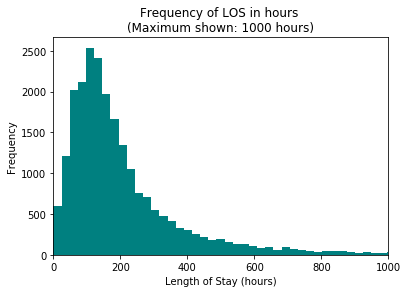

In [9]:
plt.hist(df_ADMISSIONS['LOS_hr'], bins=200, color = 'teal')
plt.ylabel('Frequency')
plt.xlabel('Length of Stay (hours)')
plt.title('Frequency of LOS in hours \n(Maximum shown: 1000 hours)')
plt.xlim(0, 1000)
plt.show();

In [10]:
skew(df_ADMISSIONS['LOS_hr'])

4.712024031861701

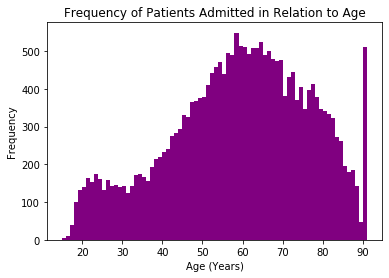

In [11]:
plt.hist(df_ADMISSIONS.AGE, bins = 76, color = 'purple')
plt.title('Frequency of Patients Admitted in Relation to Age')
plt.ylabel('Frequency')
plt.xlabel('Age (Years)')
plt.show()

In [12]:
df_ADMISSIONS.AGE.describe()

count    22918.000000
mean        58.616590
std         17.589276
min         15.000000
25%         47.000000
50%         60.000000
75%         72.000000
max         91.000000
Name: AGE, dtype: float64

In [35]:
df_ADMISSIONS = df_ADMISSIONS.drop(columns = ['index','level_0', 'ROW_ID_x' ])

In [36]:
df_ADMISSIONS.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME',
       'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
       'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG',
       'HAS_CHARTEVENTS_DATA', 'ROW_ID_y', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP',
       'DOD_SSN', 'EXPIRE_FLAG', '_merge', 'LOS_hr', 'AGE'],
      dtype='object')

In [38]:
agelst = []
for i in range(0,22918):
    if df_ADMISSIONS.iloc[i, -1] < 40:
        agelst.append(1)
    elif df_ADMISSIONS.iloc[i, -1] > 39 and df_ADMISSIONS.iloc[i, -1] < 60:
        agelst.append(2)
    elif df_ADMISSIONS.iloc[i, -1] > 59 and df_ADMISSIONS.iloc[i, -1] < 70:
        agelst.append(3)
    elif df_ADMISSIONS.iloc[i, -1] > 69 and df_ADMISSIONS.iloc[i, -1] < 75:
        agelst.append(4)
    elif df_ADMISSIONS.iloc[i, -1] > 74 and df_ADMISSIONS.iloc[i, -1] < 80:
        agelst.append(5)
    elif df_ADMISSIONS.iloc[i, -1] > 79:
        agelst.append(6)

In [40]:
df_ADMISSIONS['AGEdict'] = agelst

In [43]:
age_dictionary = {
    1 : '<40',
    2 : '40-59',
    3 : '60-69',
    4 : '70-74',
    5 : '74-79',
    6 : '> 79'
}
df_ADMISSIONS.AGEdict.replace(age_dictionary, inplace=True)
df_ADMISSIONS.AGEdict.value_counts()

40-59    7744
60-69    4968
<40      3500
> 79     2791
70-74    2033
74-79    1882
Name: AGEdict, dtype: int64

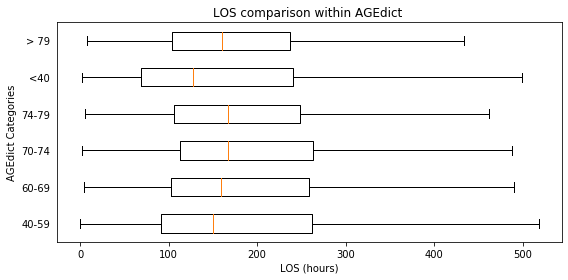

In [44]:
def boxplot_los_groupby(variable, los_range=(-1, 30) ,size=(8,4)):
    ''' 
    Boxplot of LOS by df categorical series name 
    '''
    results = df_ADMISSIONS[[variable, 'LOS_hr']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df_ADMISSIONS['LOS_hr'].loc[df_ADMISSIONS[variable]==cat].values)
    
    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_yticklabels(categories)
    ax.set_ylabel('{} Categories'.format(variable))
    ax.set_xlabel('LOS (hours)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('LOS comparison within {} '.format(variable))
    plt.tight_layout()
    plt.show();
    
boxplot_los_groupby('AGEdict', los_range=(-1, 300))

In [45]:
results = df_ADMISSIONS[['AGEdict', 'LOS_hr']].groupby('AGEdict').median().reset_index()
categories = results['AGEdict'].values.tolist()
arrays = []
for cat in categories:
    arrays.append(df_ADMISSIONS['LOS_hr'].loc[df_ADMISSIONS['AGEdict']==cat].values)
print(categories)
f_oneway(arrays[0],arrays[1],arrays[2])

['40-59', '60-69', '70-74', '74-79', '<40', '> 79']


F_onewayResult(statistic=1.1263825003958807, pvalue=0.32423184556055834)

In [110]:
marriage_dictionary = {
   "SINGLE" : "SINGLE",
   "MARRIED" : "MARRIED",
   "DIVORCED" : "MARRIAGE ENDED",
   "WIDOWED" : "MARRIAGE ENDED",
   "SEPARATED" : "MARRIAGE ENDED",
   "UNKNOWN (DEFAULT)" : "UNKNOWN",
   "LIFE PARTNER" : "MARRIED"
                      }

df_ADMISSIONS.MARITAL_STATUS.replace(marriage_dictionary, inplace=True)
df_ADMISSIONS.MARITAL_STATUS.value_counts()

MARRIED           11422
SINGLE             6439
MARRIAGE ENDED     3816
UNKNOWN             140
Name: MARITAL_STATUS, dtype: int64

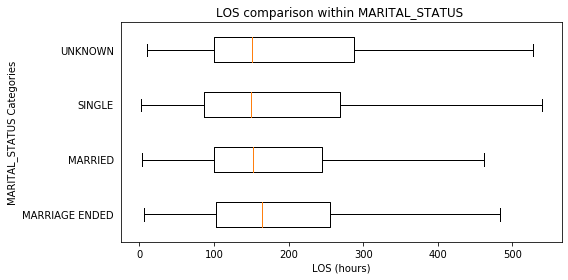

In [111]:
boxplot_los_groupby('MARITAL_STATUS', los_range=(-1, 300))

In [112]:
results = df_ADMISSIONS[['MARITAL_STATUS', 'LOS_hr']].groupby('MARITAL_STATUS').median().reset_index()
categories = results['MARITAL_STATUS'].values.tolist()
arrays = []
for cat in categories:
    arrays.append(df_ADMISSIONS['LOS_hr'].loc[df_ADMISSIONS['MARITAL_STATUS']==cat].values)
print(categories)
f_oneway(arrays[0],arrays[1],arrays[2])

['MARRIAGE ENDED', 'MARRIED', 'SINGLE', 'UNKNOWN']


F_onewayResult(statistic=14.924684294228008, pvalue=3.332354283453077e-07)

In [113]:
## Unknown 0, White 1, Black 2, Hispanic 3, Asian 4, Other 5
ethnicity_dictionary = {
    'WHITE' : 'WHITE',
    'UNKNOWN/NOT SPECIFIED' : 'UNKNOWN',
    'MULTI RACE ETHNICITY' : 'UNKNOWN',
    'BLACK/AFRICAN AMERICAN' : 'BLACK',
    'HISPANIC OR LATINO' : 'HISPANIC',
    'PATIENT DECLINED TO ANSWER' : 'UNKNOWN',
    'ASIAN': 'ASIAN',
    'OTHER' : 'OTHER',
    'HISPANIC/LATINO - GUATEMALAN' : 'HISPANIC',
    'ASIAN - VIETNAMESE' : 'ASIAN',
    'AMERICAN INDIAN/ALASKA NATIVE' : 'OTHER',
    'WHITE - RUSSIAN' : 'WHITE',
    'HISPANIC/LATINO - PUERTO RICAN' : 'HISPANIC',
    'ASIAN - ASIAN INDIAN' : 'ASIAN',
    'HISPANIC/LATINO - SALVADORAN' : 'HISPANIC',
    'HISPANIC/LATINO - DOMINICAN' : 'HISPANIC',
    'UNABLE TO OBTAIN' : 'UNKNOWN',
    'ASIAN - CHINESE' : 'ASIAN',
    'BLACK/CAPE VERDEAN' : 'BLACK',
    'WHITE - OTHER EUROPEAN' : 'WHITE',
    'PORTUGUESE' : 'WHITE',
    'BLACK/HAITIAN' : 'BLACK',
    'SOUTH AMERICAN' : 'HISPANIC',
    'CARIBBEAN ISLAND' : 'BLACK',
    'WHITE - EASTERN EUROPEAN' : 'WHITE',
    'ASIAN - FILIPINO' : 'ASIAN',
    'ASIAN - CAMBODIAN' : 'ASIAN',
    'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)' : 'HISPANIC',
    'WHITE - BRAZILIAN' : 'WHITE',
    'HISPANIC/LATINO - COLOMBIAN' : 'HISPANIC',
    'ASIAN - JAPANESE' : 'ASIAN',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER' : 'OTHER',
    'BLACK/AFRICAN' : 'BLACK',
    'ASIAN - THAI' : 'ASIAN',
    'HISPANIC/LATINO - HONDURAN' : 'HISPANIC',
    'MIDDLE EASTERN' : 'OTHER',
    'ASIAN - OTHER' : 'ASIAN',
    'HISPANIC/LATINO - CUBAN' : 'HISPANIC',
    'HISPANIC/LATINO - MEXICAN' : 'HISPANIC',
    'ASIAN - KOREAN' : 'ASIAN',
    'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE' : 'OTHER'
                       }
df_ADMISSIONS.ETHNICITY.replace(ethnicity_dictionary, inplace=True)
df_ADMISSIONS.ETHNICITY.value_counts()

WHITE       16192
UNKNOWN      2650
BLACK        1875
HISPANIC      952
OTHER         658
ASIAN         591
Name: ETHNICITY, dtype: int64

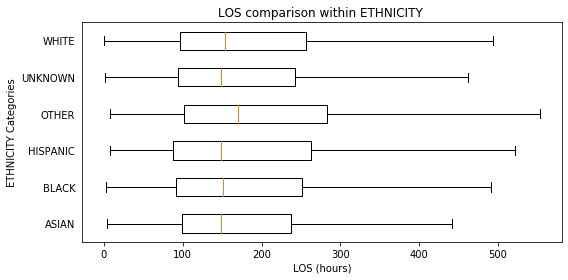

In [114]:
boxplot_los_groupby('ETHNICITY')

In [115]:
results = df_ADMISSIONS[['ETHNICITY', 'LOS_hr']].groupby('ETHNICITY').median().reset_index()
categories = results['ETHNICITY'].values.tolist()
arrays = []
for cat in categories:
    arrays.append(df_ADMISSIONS['LOS_hr'].loc[df_ADMISSIONS['ETHNICITY']==cat].values)
print(categories)
f_oneway(arrays[0],arrays[1],arrays[2],arrays[3],arrays[5])

['ASIAN', 'BLACK', 'HISPANIC', 'OTHER', 'UNKNOWN', 'WHITE']


F_onewayResult(statistic=1.7023465148890136, pvalue=0.1463564467198609)

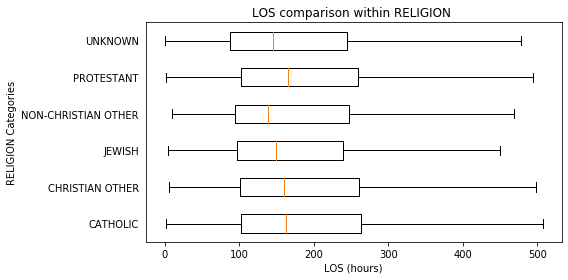

In [116]:
# UNKNOWN = 0, CATHOLIC = 1, PROTESTANT = 2, JEWISH = 3, CHRISTIAN OTHER = 4, NON-CHRISTIAN OTHER = 5
religion_dictionary = {
    'UNOBTAINABLE' : 'UNKNOWN',
    'CATHOLIC' : 'CATHOLIC',
    'PROTESTANT QUAKER' : 'PROTESTANT',
    'NOT SPECIFIED' : 'UNKNOWN',
    'JEWISH' : 'JEWISH',
    'BUDDHIST' : 'NON-CHRISTIAN OTHER',
    'OTHER' : 'UNKNOWN',
    "JEHOVAH'S WITNESS" : 'CHRISTIAN OTHER',
    'GREEK ORTHODOX' : 'CHRISTIAN OTHER',
    'EPISCOPALIAN' : 'CHRISTIAN OTHER',
    'HINDU' : 'NON-CHRISTIAN OTHER',
    'CHRISTIAN SCIENTIST' : 'CHRISTIAN OTHER',
    'HEBREW' : 'JEWISH',
    'METHODIST' : 'CHRISTIAN OTHER',
    'UNITARIAN-UNIVERSALIST' : 'CHRISTIAN OTHER',
    'BAPTIST' : 'CHRISTIAN OTHER',
    '7TH DAY ADVENTIST' : 'CHRISTIAN OTHER',
    'MUSLIM' : 'NON-CHRISTIAN OTHER',
    'ROMANIAN EAST. ORTH' : 'CHRISTIAN OTHER',
    'LUTHERAN' : 'CHRISTIAN OTHER'
}
df_ADMISSIONS.RELIGION.replace(religion_dictionary, inplace=True)
df_ADMISSIONS.RELIGION.value_counts()
boxplot_los_groupby('RELIGION')

In [117]:
results = df_ADMISSIONS[['RELIGION', 'LOS_hr']].groupby('RELIGION').median().reset_index()
categories = results['RELIGION'].values.tolist()
arrays = []
for cat in categories:
    arrays.append(df_ADMISSIONS['LOS_hr'].loc[df_ADMISSIONS['RELIGION']==cat].values)
print(categories)
f_oneway(arrays[0],arrays[1],arrays[2],arrays[3],arrays[4])

['CATHOLIC', 'CHRISTIAN OTHER', 'JEWISH', 'NON-CHRISTIAN OTHER', 'PROTESTANT', 'UNKNOWN']


F_onewayResult(statistic=6.438830295090239, pvalue=3.583280065483362e-05)

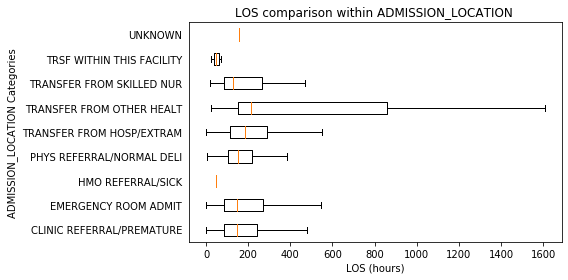

In [118]:
admission_location_dictionary = {
    'EMERGENCY ROOM ADMIT' : 'EMERGENCY ROOM ADMIT',
    'PHYS REFERRAL/NORMAL DELI' : 'PHYS REFERRAL/NORMAL DELI',
    'TRANSFER FROM HOSP/EXTRAM' : 'TRANSFER FROM HOSP/EXTRAM',
    'CLINIC REFERRAL/PREMATURE' : 'CLINIC REFERRAL/PREMATURE', 
    'TRANSFER FROM SKILLED NUR' : 'TRANSFER FROM SKILLED NUR',
    'HMO REFERRAL/SICK' : 'HMO REFERRAL/SICK',
    '** INFO NOT AVAILABLE **' : 'UNKNOWN',
    'TRANSFER FROM OTHER HEALT' : 'TRANSFER FROM OTHER HEALT',
    'TRSF WITHIN THIS FACILITY' : 'TRSF WITHIN THIS FACILITY'
}
df_ADMISSIONS.ADMISSION_LOCATION.replace(admission_location_dictionary, inplace=True)
df_ADMISSIONS.ADMISSION_LOCATION.value_counts()
boxplot_los_groupby('ADMISSION_LOCATION')

In [119]:
results = df_ADMISSIONS[['ADMISSION_LOCATION', 'LOS_hr']].groupby('ADMISSION_LOCATION').median().reset_index()
categories = results['ADMISSION_LOCATION'].values.tolist()
arrays = []
for cat in categories:
    arrays.append(df_ADMISSIONS['LOS_hr'].loc[df_ADMISSIONS['ADMISSION_LOCATION']==cat].values)
print(categories)
f_oneway(arrays[0],arrays[1],arrays[2],arrays[3],arrays[4],arrays[5],arrays[6],arrays[7])

['CLINIC REFERRAL/PREMATURE', 'EMERGENCY ROOM ADMIT', 'HMO REFERRAL/SICK', 'PHYS REFERRAL/NORMAL DELI', 'TRANSFER FROM HOSP/EXTRAM', 'TRANSFER FROM OTHER HEALT', 'TRANSFER FROM SKILLED NUR', 'TRSF WITHIN THIS FACILITY', 'UNKNOWN']


F_onewayResult(statistic=28.368543476114173, pvalue=3.445112637836628e-39)

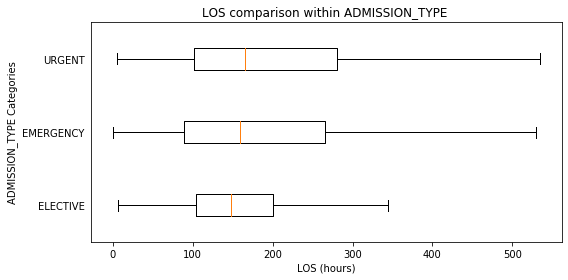

In [120]:
admission_type_dictionary = {
    'EMERGENCY' : 'EMERGENCY',
    'ELECTIVE' : 'ELECTIVE',
    'NEWBORN' : 'NEWBORN',
    'URGENT' : 'URGENT'
}
df_ADMISSIONS.ADMISSION_TYPE.replace(admission_type_dictionary, inplace=True)
df_ADMISSIONS.ADMISSION_TYPE.value_counts()
boxplot_los_groupby('ADMISSION_TYPE')

In [121]:
results = df_ADMISSIONS[['ADMISSION_TYPE', 'LOS_hr']].groupby('ADMISSION_TYPE').median().reset_index()
categories = results['ADMISSION_TYPE'].values.tolist()
arrays = []
for cat in categories:
    arrays.append(df_ADMISSIONS['LOS_hr'].loc[df_ADMISSIONS['ADMISSION_TYPE']==cat].values)
print(categories)
f_oneway(arrays[0],arrays[1],arrays[2])

['ELECTIVE', 'EMERGENCY', 'URGENT']


F_onewayResult(statistic=57.42552457755396, pvalue=1.326486075179285e-25)

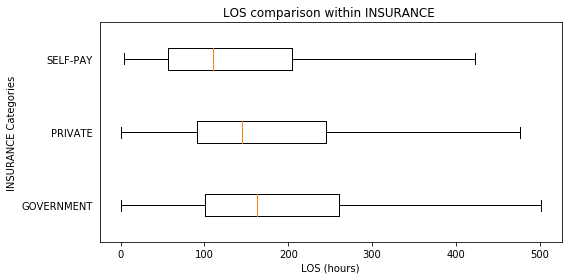

In [122]:
insurance_dictionary = {
    'Private' : 'PRIVATE', 
    'Medicare' : 'GOVERNMENT', 
    'Medicaid' : 'GOVERNMENT', 
    'Self Pay' : 'SELF-PAY', 
    'Government' : 'GOVERNMENT'
}
df_ADMISSIONS.INSURANCE.replace(insurance_dictionary, inplace=True)
df_ADMISSIONS.INSURANCE.value_counts()
boxplot_los_groupby('INSURANCE')

In [123]:
results = df_ADMISSIONS[['INSURANCE', 'LOS_hr']].groupby('INSURANCE').median().reset_index()
categories = results['INSURANCE'].values.tolist()
categories = results['INSURANCE'].values.tolist()
arrays = []
for cat in categories:
    arrays.append(df_ADMISSIONS['LOS_hr'].loc[df_ADMISSIONS['INSURANCE']==cat].values)
print(categories)
f_oneway(arrays[0],arrays[1],arrays[2])

['GOVERNMENT', 'PRIVATE', 'SELF-PAY']


F_onewayResult(statistic=17.40533102457085, pvalue=2.7970261102822993e-08)

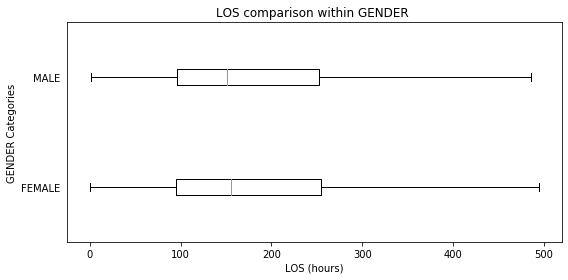

In [124]:
gender_dictionary = {
    "M": 'MALE',
    "F" : 'FEMALE'
}
df_ADMISSIONS.GENDER.replace(gender_dictionary, inplace=True)
df_ADMISSIONS.GENDER.value_counts()
boxplot_los_groupby('GENDER')

In [125]:
results = df_ADMISSIONS[['GENDER', 'LOS_hr']].groupby('GENDER').median().reset_index()
categories = results['GENDER'].values.tolist()
categories = results['GENDER'].values.tolist()
arrays = []
for cat in categories:
    arrays.append(df_ADMISSIONS['LOS_hr'].loc[df_ADMISSIONS['GENDER']==cat].values)
print(categories)
f_oneway(arrays[0],arrays[1])

['FEMALE', 'MALE']


F_onewayResult(statistic=0.6412821245444061, pvalue=0.42325520450974186)